In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import astropy.io.fits as fits

import glob

from lsst.sims.photUtils.Sed import Sed
from lsst.sims.photUtils.Bandpass import Bandpass

import os

from sklearn.neighbors import KDTree

# Stellar template library:

In [11]:
with np.load('model_atm_mags.npz') as nump_zip:
    
    model_atm_mags = nump_zip['model_atm_mags']

# Simulated LSST data:

In [12]:
temp = np.load('stars_from_catsim.npz')

sim_data = temp['from_catsim'].copy()
temp.close()

In [14]:
plt.style.use('ggplot')

## Transforming simulated "g", "r", and "i" data to other LSST broadband filter mags based on coefficients from the model library:

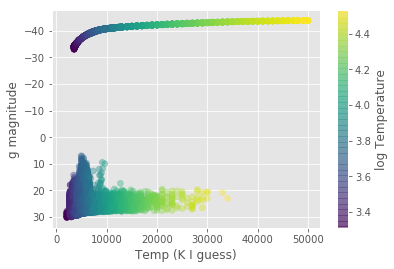

In [22]:
plt.scatter(model_atm_mags['Teff'], model_atm_mags['g'],
            c=np.log10(model_atm_mags['Teff']), alpha=.5)
plt.scatter(sim_data['teff'], sim_data['gmag'],
            c=np.log10(sim_data['teff']), alpha=.4)
cb = plt.colorbar()
cb.set_label('log Temperature')
plt.gca().invert_yaxis()
plt.xlabel('Temp (K I guess)')
plt.ylabel('g magnitude');

# Oh, it's not linear. Of course it's not fucking linear. Duh.

## Object for creating KD tree from stellar templates and using it to identify Teff, log(Z), etc., from input colors:

In [5]:
class stellar_param_fitter(object):
    
    '''Makes a kd-tree based on stellar models for the purposes of identifying the properties of
    input star(s).'''
    
    def __init__(self, colors=['g-r','r-i']):
        # colors must be a list of 'band1-band2'
        
        # Read in the saved array and construct the kdtree with the given colors
        temp = np.load('model_atm_mags.npz')
        # Have to copy to get it into memory, otherwise it reads off disk every time
        self.model_atm_cols = []
        self.model_atm_magstest = temp['model_atm_mags'].copy()
        for colorStr in colors:
            band1,band2=colorStr.split("-")
            color = self.model_atm_magstest[band1] - self.model_atm_magstest[band2]
            self.model_atm_cols.append(color)
        temp.close()
        # Construct kdtree
        self.model_atm_cols = np.array(self.model_atm_cols).T
        self.kdtree = KDTree(self.model_atm_cols)
        
    def __call__(self, input_colors):
        
        # Input colors could be a single measurement, or an array with 
        # Querry the kd-tree.
        dist, ind = self.kdtree.query(input_colors, k=1)
        # Construct an array to hold the results
        keys = ['Teff', 'gravity', 'log_Z']
        output = {}
        for key in keys:
            output[key] = self.model_atm_magstest[key][ind]
        return output

In [8]:
model = stellar_param_fitter()